In [1]:
import numpy as np
import tensorflow as tf
import datetime
import load_patches
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline
%load_ext tensorboard

**Settings**

In [2]:
filename = 'CS8_ROIs.csv'
folder = 'cellsuspensionED8/'
patch_size = 23

# Clipping parameter for histogram equalisation
clip_limit = 0.03


batch_size = 100
epochs = 15

**Load data**

In [3]:
X, y = load_patches.get_patches_and_labels(filename, folder, patch_size, clip_limit)

**Create training and validation sets**

In [4]:
def cast(x, y):
    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.int64)
    return x, y

def create_dataset(x, y, n_classes=2):
    if n_classes > 2:
        y = tf.one_hot(y, depth=n_classes)
    return tf.data.Dataset.from_tensor_slices((x, y)).map(cast).shuffle(len(y)).batch(100)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [6]:
train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)

**Define the model**

In [7]:
# model = keras.Sequential([
#     keras.layers.Reshape(target_shape=(23 * 23,), input_shape=(23, 23)),
#     keras.layers.Dense(units=256, activation='relu'),
#     keras.layers.Dense(units=192, activation='relu'),
#     keras.layers.Dense(units=128, activation='relu'),
#     keras.layers.Dense(units=10, activation='softmax')
# ])

# model = keras.Sequential([
#     keras.layers.Reshape(target_shape=(patch_size, patch_size , 1), input_shape=(patch_size, patch_size)),
#     keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
#     keras.layers.MaxPooling2D(),
#     keras.layers.Dropout(0.2),
#     keras.layers.Flatten(),
#     keras.layers.Dense(1024, activation='relu'),
#     keras.layers.Dense(1, activation='sigmoid')
# ])

model = keras.Sequential([
    keras.layers.Reshape(target_shape=(patch_size, patch_size , 1), input_shape=(patch_size, patch_size)),
    keras.layers.Conv2D(16, 5, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 23, 23, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 16)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       keras.metrics.AUC(name='auc')])

In [10]:
log_dir = "logs/" + datetime.datetime.now().strftime("%d.%m.%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
model.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds, 
    validation_steps=2,
    callbacks=[tensorboard_callback]
)

Epoch 1/15
558/558 [==============================] - 39s 70ms/step - loss: 0.4474 - accuracy: 0.7852 - precision: 0.7726 - recall: 0.8079 - auc: 0.8693 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00
Epoch 2/15
558/558 [==============================] - 36s 65ms/step - loss: 0.3533 - accuracy: 0.8437 - precision: 0.8180 - recall: 0.8839 - auc: 0.9196 - val_loss: 0.3573 - val_accuracy: 0.8350 - val_precision: 0.8142 - val_recall: 0.8846 - val_auc: 0.9220
Epoch 3/15
558/558 [==============================] - 35s 64ms/step - loss: 0.3254 - accuracy: 0.8585 - precision: 0.8341 - recall: 0.8949 - auc: 0.9318 - val_loss: 0.3353 - val_accuracy: 0.8400 - val_precision: 0.7931 - val_recall: 0.9200 - val_auc: 0.9341
Epoch 4/15
558/558 [==============================] - 36s 64ms/step - loss: 0.3041 - accuracy: 0.8689 - precision: 0.8437 - recall: 0.9053 - auc: 0.9404 - val_loss: 0.3052 - val_accuracy: 0.8800 - val_preci

**Evaluate the model**

In [12]:
y_val_proba = model.predict_proba(X_val)

In [13]:
threshold = 0.5
y_val_pred = np.where(y_val_proba > threshold, 1, 0)

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(precision_score(y_val, y_val_pred))
print(recall_score(y_val, y_val_pred))
print(f1_score(y_val, y_val_pred))

0.8761917733587579
0.9212372905627954
0.898150087260035


In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_val_pred)

array([[6036,  909],
       [ 550, 6433]])

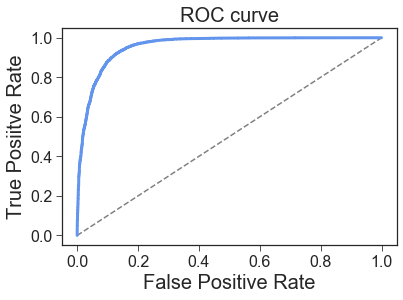

In [16]:
from sklearn.metrics import roc_curve
import seaborn as sns
plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    sns.lineplot(x=fpr, y=tpr, estimator=None, color='cornflowerblue', linewidth=3, label=label)
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Posiitve Rate')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    
plot_roc_curve(fpr, tpr)

plt.savefig('./results/ROC.png', bbox_inches='tight', dpi=300);

**Make predictions on new data**

In [18]:
filename = 'PE8_ROIs.csv'
folder = 'plaineggED8/'
name = 'egg46'
region_size = 148
X_test = load_patches.get_patches(filename, folder, patch_size, clip_limit, 'egg46')

In [19]:
X_test = tf.cast(X_test, tf.float32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test))

In [20]:
y_test_proba = model.predict_proba(X_test)

In [21]:
threshold = 0.8
y_test_pred = np.where(y_test_proba > threshold, 1, 0)

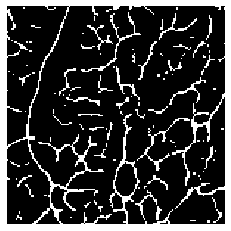

In [22]:
plt.imshow(y_test_pred.reshape([-1, region_size, region_size])[0], 
           cmap = plt.cm.gray, interpolation = "nearest");
plt.axis('off');
plt.savefig('./results/test1.png', bbox_inches='tight', dpi=300);

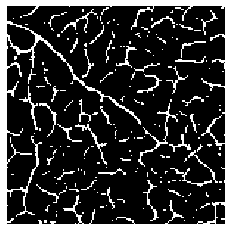

In [23]:
plt.imshow(y_test_pred.reshape([-1, region_size, region_size])[1], 
           cmap = plt.cm.gray, interpolation = "nearest");
plt.axis('off');
plt.savefig('./results/test2.png', bbox_inches='tight', dpi=300);

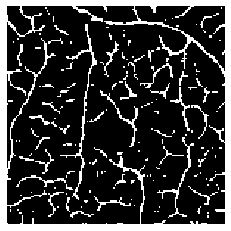

In [24]:
plt.imshow(y_test_pred.reshape([-1, region_size, region_size])[2], 
           cmap = plt.cm.gray, interpolation = "nearest");
plt.axis('off');
plt.savefig('./results/test3.png', bbox_inches='tight', dpi=300);